In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from numpy.random import poisson as poi
import time
import genSIRUniverse as gsu
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from pydiffmap import diffusion_map as dm

%matplotlib inline
%load_ext autoreload
%autoreload 2

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
#Some global definitions
state_loc = {"S":0, "I":1, "R":2}

# Objectives.
Given a set of SIR states of an ensemble of similar systems each at a particular stage of its own epidemic, can we infer the common constraints between these systems? An example could be the connectivity between the nodes, which we will hold constant within the ensemble. 

1. These constraints should reduce the possible time-states that these systems can take. This reduction is manifest in thermodynamic ensembles. For example, the fact that energy is conserved in the microcanonical ensemble leads to manifold in their phase space. This manifold, in turn, gives us the Maxwell relations between the state variables $S,T,E,p,V$. In the case of epidemics, sufficiently many time-states from a network-constrained ensemble should stitch together to form a manifold. The first objective is to attempt to make these manifolds apparent using dimensionality reduction and/or manifold learning techniques.
2. There will still be many residual degrees of freedom (d.o.f.) in this ensemble despite these constraints. These d.o.f. will probe the extent of the manifold. The second objective is to use manifold learning techniques to delineate the boundaries of the manifold. 

------ 
# Ensemble test on von-Neumann connectivity.
- Notice the ring-like structure of the low-order PCA components for the above ring-like topology disappears here. 
- Which end-state should you pick to do PCA-reduction? This is related to the average population per node. 

In [19]:
%%time
states,errs = ([],[])
universe_shape = (4,4)
(max_steps, global_alpha, global_beta, global_gamma) = (100, 0.01, 0.8, 0.2)
conn = gsu.gen_von_neumann(*universe_shape)
while len(errs) < 500:
    #initialise the simulation parameters
    try:
        su0 = gsu.sir_universe(universe_sh=universe_shape, conn=conn, alpha=global_alpha, 
                               beta=global_beta, gamma=global_gamma,
                              avg_pop_per_node=1000)
        su0.initialize()
        su0.iterate(max_steps)
        #Here we only select simulations that do not terminate prematurely, 
        #and also those that continue to fluctuate measurably
        err = np.asarray([np.linalg.norm(n) for n in (su0.np_state[1:]-su0.np_state[:-1])])
        if (err[-1] < 1.E-3)|(len(err)< max_steps):
            continue
    except:
        continue
    errs.append(err.copy())
    states.append(su0.np_state.copy())
    print('Case number {:d}'.format(len(errs)), end='\r')
states = np.asarray(states)
errs = np.asarray(errs)

CPU times: user 17.9 s, sys: 488 ms, total: 18.3 s
Wall time: 18 s


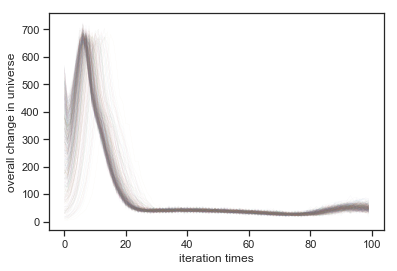

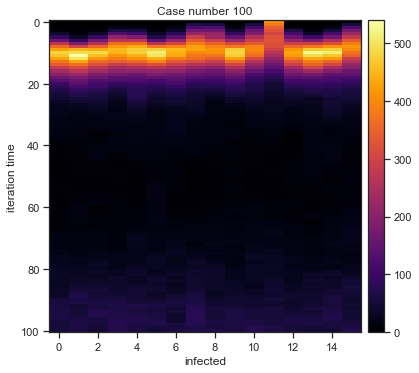

In [20]:
for e in errs:
    plt.plot(e, lw=.02)
plt.xlabel('iteration times')
plt.ylabel('overall change in universe')
#plt.yscale('log')

case_num = 100
gsu.my_single_imshow(states[case_num][:, state_loc["I"],:], xlabel="infected", ylabel="iteration time", title="Case number {:d}".format(case_num))

#### Again, we first look at the early $t^\ast = 15$ states when nearly all sites show substantial numbers of infections.**

The PCA 'eigenvalues' suggest that there are about 5 effective degrees of freedom in this ensemble. What do these degrees of freedom signify?

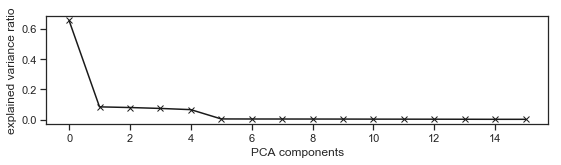

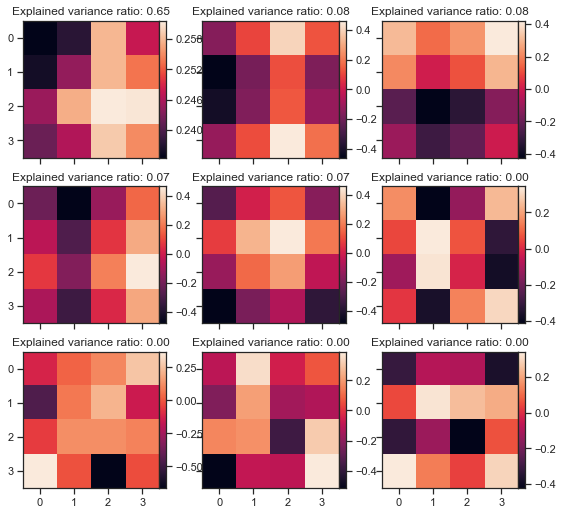

In [23]:
it_num = 15
input_arr = states[:, it_num, state_loc["I"]]
pca_model, pca_transformed_input = gsu.pca_and_view(input_arr, num_components=16, plot=False)

gsu.view_pca_2(pca_model, universe_shape, show_shape=(3,3), punit=3)

#### There is clearly some sub-structure that emerges here, evident in the pair-wise plots between the PCA components.
In some projections, you can clearly **see up to 6 disjoint clusters.** 
- What do these clusters signify?

/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


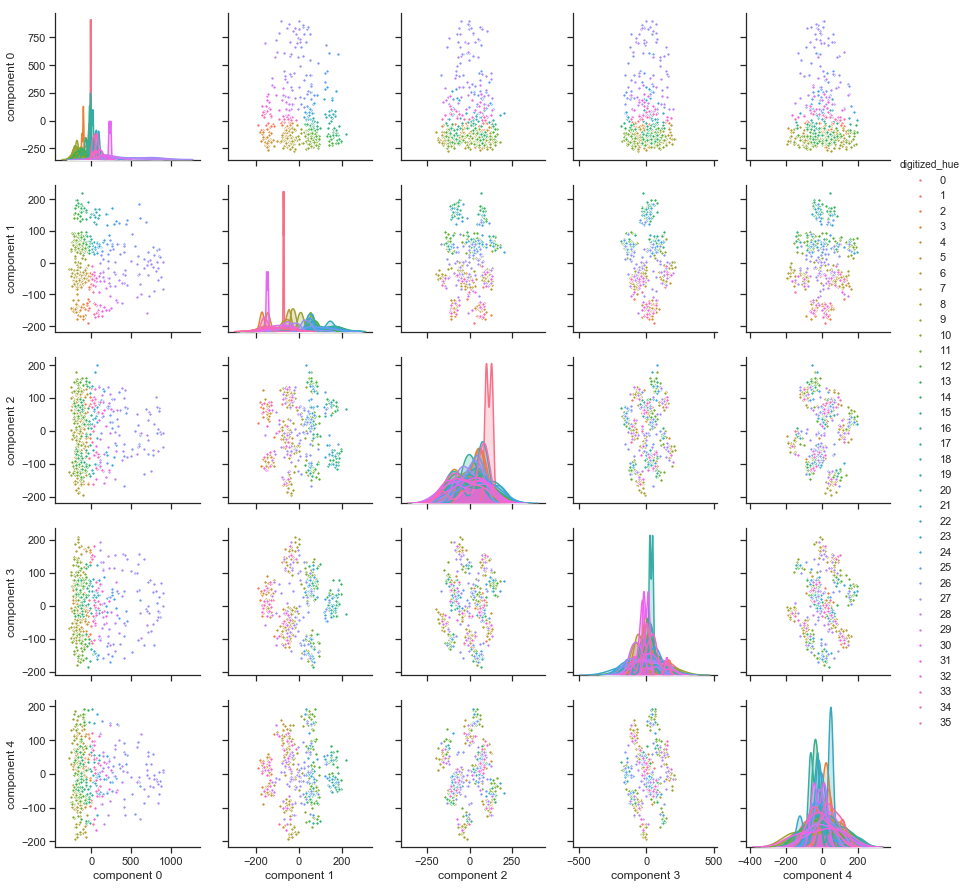

In [24]:
num_comp_to_show = 5
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['digitized_hue'] = ((181+180*np.arctan2(df["component 0"], df["component 1"])/np.pi)/10.).astype('int')
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], hue="digitized_hue", plot_kws={"s":10})

## Let's see what happens when the simulation universe increases by 4 times. 
We should also increase the number of samples (because of the curse of high dimensionality).
- In the 4x4 universe we had 500 epidemics starting from random single nodes. This gave each node about 30 chances to be picked as the first infection site.
- In this 8x8 universe, we have to increase the number of cases by 4x to 2000 cases. 

In [27]:
%%time
states,errs = ([],[])
universe_shape = (8,8)
(max_steps, global_alpha, global_beta, global_gamma) = (100, 0.01, 0.8, 0.2)
conn = gsu.gen_von_neumann(*universe_shape)
while len(errs) < 2000:
    #initialise the simulation parameters
    try:
        su0 = gsu.sir_universe(universe_sh=universe_shape, conn=conn, alpha=global_alpha, 
                               beta=global_beta, gamma=global_gamma,
                              avg_pop_per_node=1000)
        su0.initialize()
        su0.iterate(max_steps)
        #Here we only select simulations that do not terminate prematurely, 
        #and also those that continue to fluctuate measurably
        err = np.asarray([np.linalg.norm(n) for n in (su0.np_state[1:]-su0.np_state[:-1])])
        if (err[-1] < 1.E-3)|(len(err)< max_steps):
            continue
    except:
        continue
    errs.append(err.copy())
    states.append(su0.np_state.copy())
    print('Case number {:d}'.format(len(errs)), end='\r')
states = np.asarray(states)
errs = np.asarray(errs)

CPU times: user 1min 11s, sys: 1.36 s, total: 1min 13s
Wall time: 1min 12s


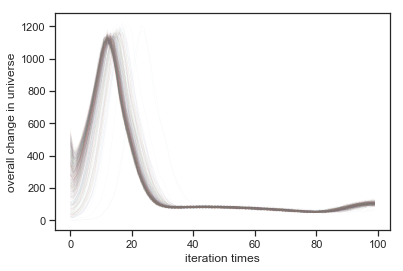

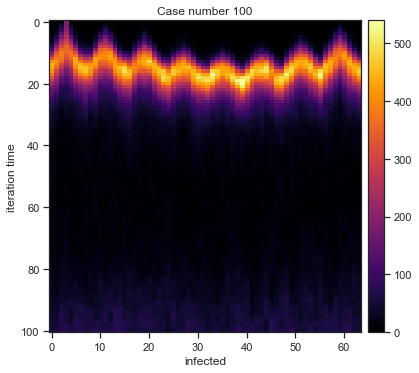

In [28]:
for n in np.random.choice(range(len(errs)),size=500, replace=False):
    plt.plot(errs[n], lw=.02)
plt.xlabel('iteration times')
plt.ylabel('overall change in universe')
#plt.yscale('log')

case_num = 100
gsu.my_single_imshow(states[case_num][:, state_loc["I"],:], xlabel="infected", ylabel="iteration time", title="Case number {:d}".format(case_num))

### Again number of significant PCA 'eigenvalues' stay around 5.
- **Note again that we picked a time state when nearly all sites show substantial numbers of infections.**
- Now we can see the von-Neumann neigbhorhood appear in the most significant PCA eigenvectors.

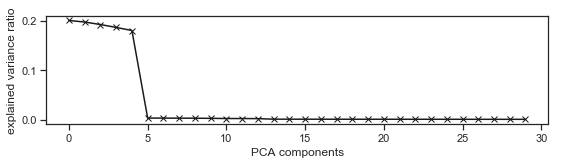

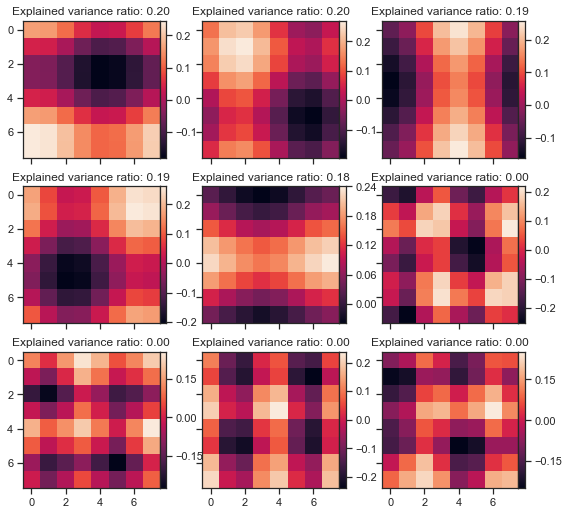

In [29]:
it_num = 20
input_arr = states[:, it_num, state_loc["I"]]
pca_model, pca_transformed_input = gsu.pca_and_view(input_arr, num_components=30, plot=False)

gsu.view_pca_2(pca_model, universe_shape, show_shape=(3,3), punit=3)

#### Again, we see interesting structure within the PCA reduced space.
- **Remarkably, the PCA analysis shows the presence of disjoint "clusters" in the manifold.**
- What do these clusters represent? What are the degrees of freedom in these sheets? 

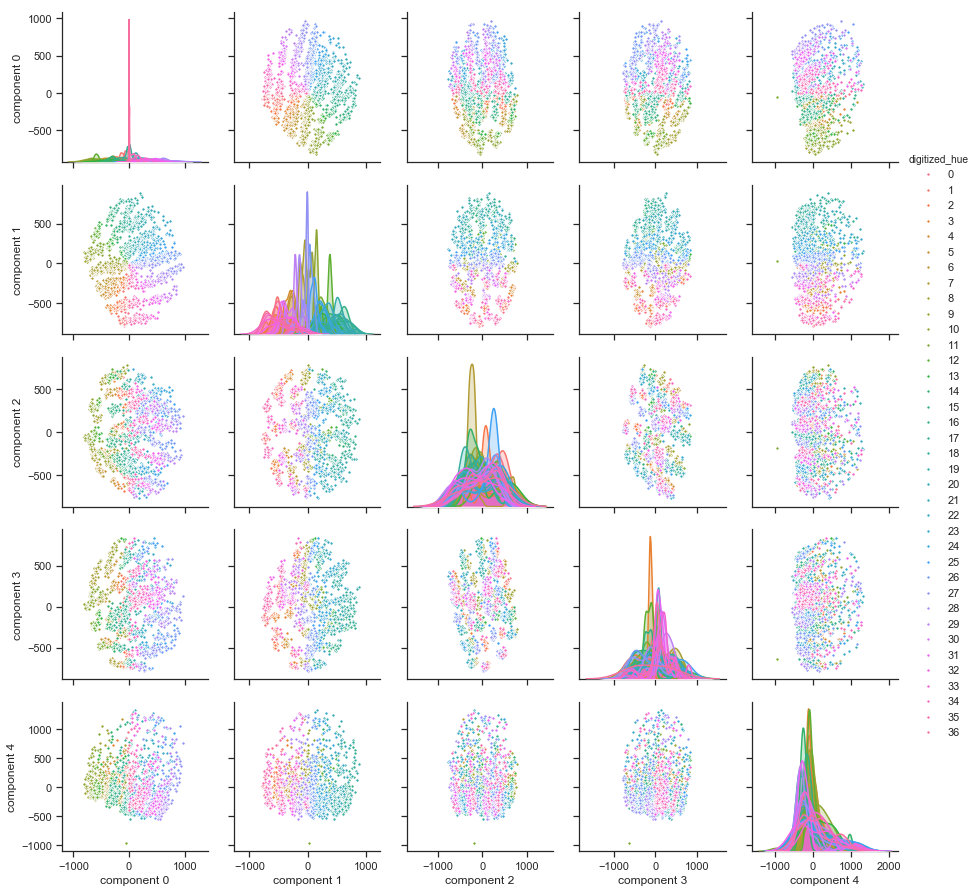

In [98]:
num_comp_to_show = 5
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['digitized_hue'] = ((181+180*np.arctan2(df["component 0"], df["component 1"])/np.pi)/10.).astype('int')
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], hue="digitized_hue", plot_kws={"s":10})

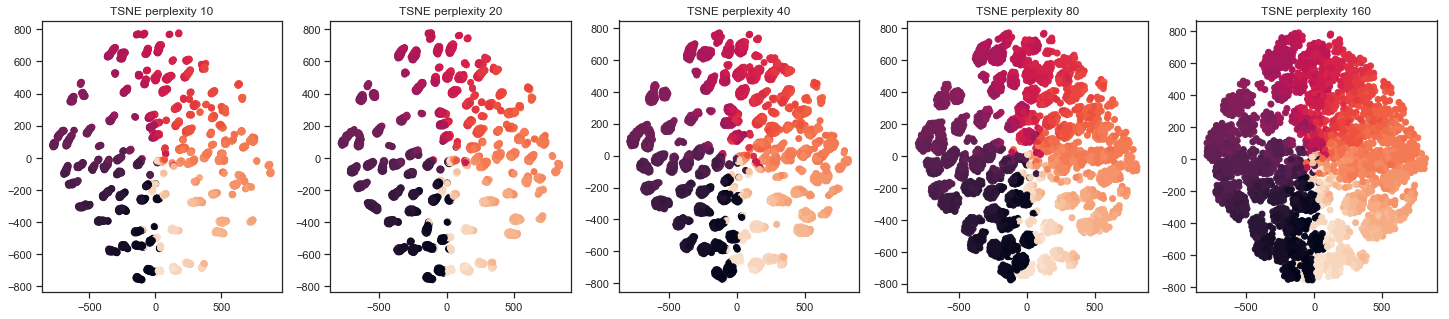

In [99]:
fig,axes = plt.subplots(1,5, figsize=(25,5))
hue_array = df['digitized_hue']

for p,ax in zip([10,20,40,80,160], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='pca', perplexity=p)
    embedding = node_position_model.fit_transform(input_arr)

    ax.scatter(embedding[:,0], embedding[:,1], c=hue_array)
    ax.set_title("TSNE perplexity {:d}".format(p))

#### These clusters likely occur because they describe the ring-like shape of an outgoing infection wave. We can see this outwards wave if we looked at snapshots of the last infection.

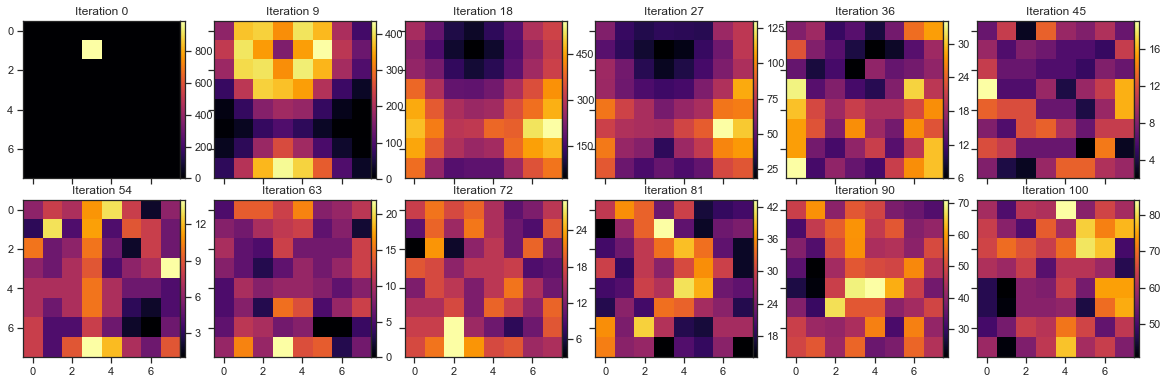

In [30]:
su0.show_snapshots(figsize=(20,10), nrows_ncols=(2,6))

## We again increase the size of the universe, this time by another 4-fold.
Again, we have to increase the number of samples in this higher-dimensional space.

***Important note: This next code bit is computationally expensive to run.***

In [31]:
%%time
states,errs = ([],[])
universe_shape = (16,16)
(max_steps, global_alpha, global_beta, global_gamma) = (100, 0.01, 0.8, 0.2)
conn = gsu.gen_von_neumann(*universe_shape)
while len(errs) < 8000:
    #initialise the simulation parameters
    try:
        su0 = gsu.sir_universe(universe_sh=universe_shape, conn=conn, alpha=global_alpha, 
                               beta=global_beta, gamma=global_gamma,
                              avg_pop_per_node=1000)
        su0.initialize()
        su0.iterate(max_steps)
        #Here we only select simulations that do not terminate prematurely, 
        #and also those that continue to fluctuate measurably
        err = np.asarray([np.linalg.norm(n) for n in (su0.np_state[1:]-su0.np_state[:-1])])
        if (err[-1] < 1.E-3)|(len(err)< max_steps):
            continue
    except:
        continue
    errs.append(err.copy())
    states.append(su0.np_state.copy())
    print('Case number {:d}'.format(len(errs)), end='\r')
states = np.asarray(states)

CPU times: user 1h 11min 40s, sys: 37.5 s, total: 1h 12min 17s
Wall time: 9min 7s


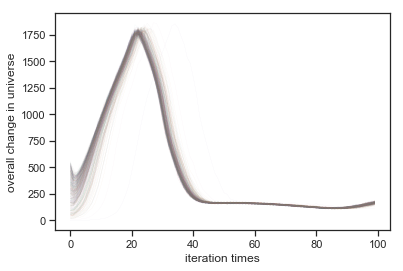

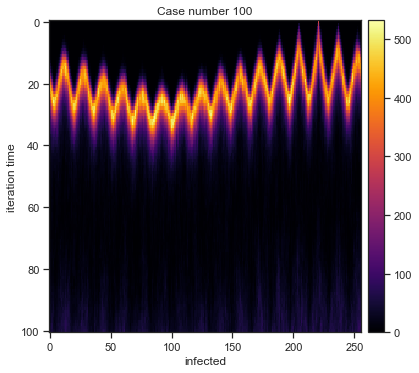

In [32]:
for n in np.random.choice(range(len(errs)),size=500, replace=False):
    plt.plot(errs[n], lw=.02)
plt.xlabel('iteration times')
plt.ylabel('overall change in universe')
#plt.yscale('log')

case_num = 100
gsu.my_single_imshow(states[case_num][:, state_loc["I"],:], xlabel="infected", ylabel="iteration time", title="Case number {:d}".format(case_num))

### The number of significant PCA 'eigenvalues' increase substantially (~20).
I suspect this comes from needing more degrees of freedom to describe the ring of infection.

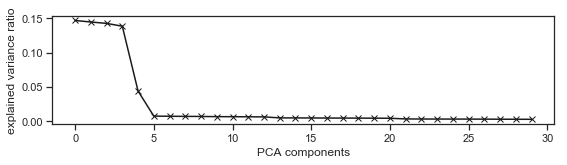

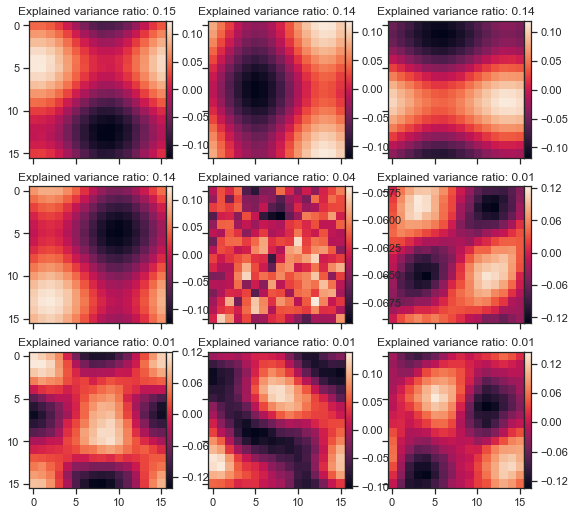

In [36]:
it_num = -1
input_arr = states[:, it_num, state_loc["I"]]
pca_model, pca_transformed_input = gsu.pca_and_view(input_arr, num_components=30, plot=False)

gsu.view_pca_2(pca_model, universe_shape, show_shape=(3,3), punit=3)

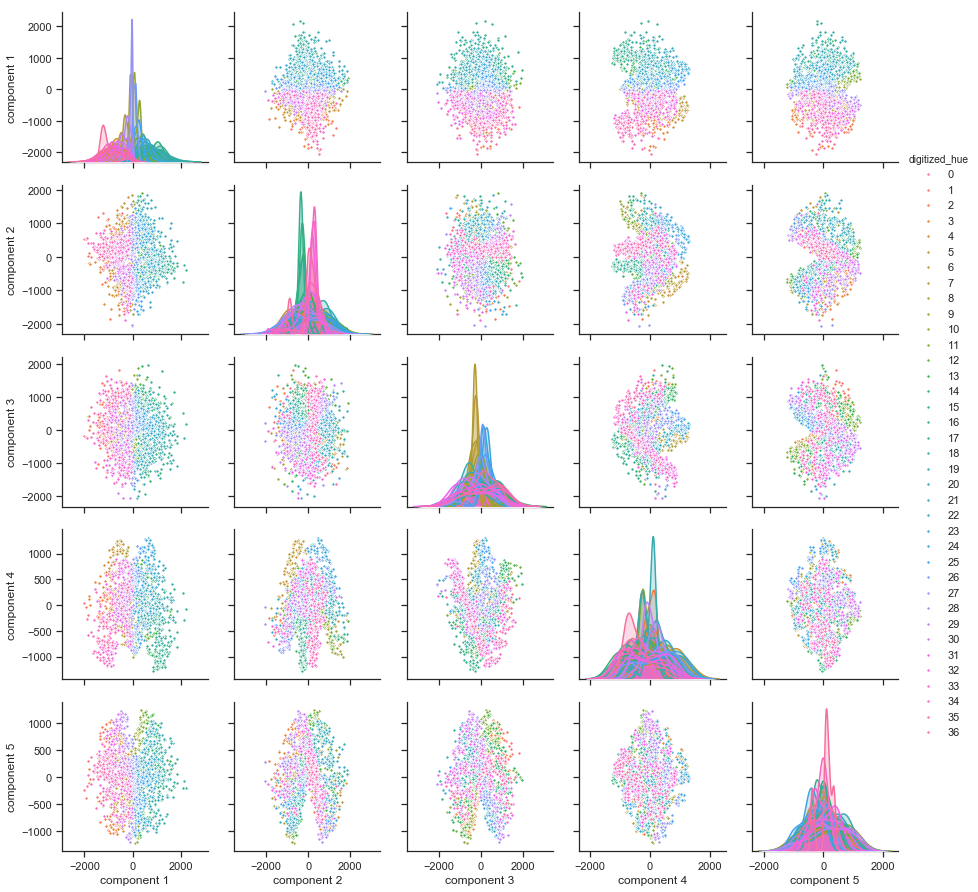

In [15]:
num_comp_to_show = 10
elems = np.random.choice(range(len(pca_transformed_input)), size=2000, replace=False)
df = pd.DataFrame(pca_transformed_input[elems])
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input[elems].T))]
df['digitized_hue'] = ((181+180*np.arctan2(df["component 0"], df["component 1"])/np.pi)/10.).astype('int')
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in [1,2,3,4,5]], hue="digitized_hue", plot_kws={"s":10})

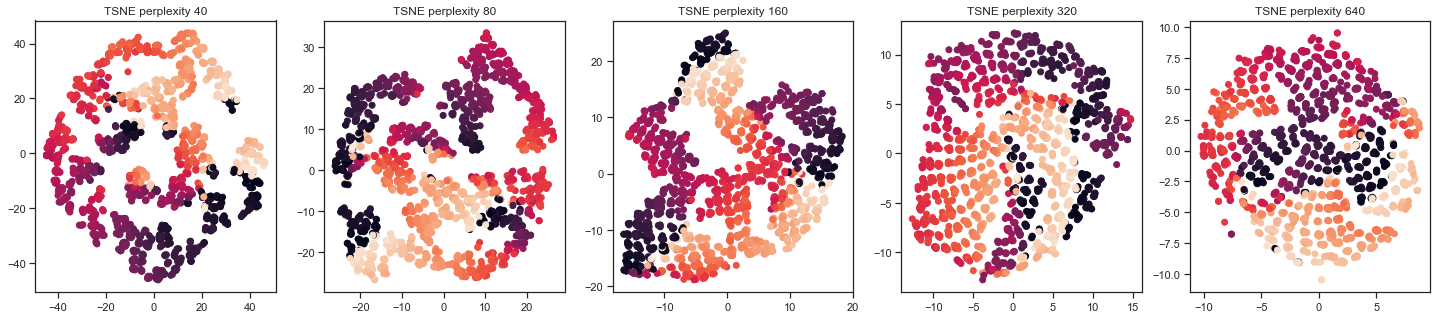

In [18]:
fig,axes = plt.subplots(1,5, figsize=(25,5))
hue_array = df['digitized_hue']

for p,ax in zip([40,80,160,320,640], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='random', perplexity=p)
    embedding = node_position_model.fit_transform(input_arr[elems])

    ax.scatter(embedding[:,0], embedding[:,1], c=hue_array)
    ax.set_title("TSNE perplexity {:d}".format(p))